## Imports

In [1]:
# Set GPU visibility
from slf_simultscoring.train import set_gpu_visibility
set_gpu_visibility("1", tf_cpu_only=False)

import sleeplab_format as slf
import sleeplab_tf_dataset as sds #Needs to be imported after setting visible devices

from pathlib import Path
import yaml
import logging

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix
import seaborn as sns

logger = logging.getLogger(__name__)
seed = 42 #make sure you have the same seed as in training

2025-11-24 12:52:44.777972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763981564.795994 1159014 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763981564.801485 1159014 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-24 12:52:44.819860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1763981566.426349 1159014 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10

### Change these:

In [ ]:
# path to configuration file
config_path = '/home/hennpi/Documents/SLF/slf-arousalscoring/config_files/tensorflow_MESA_arousals.yml'

# path to model
model_path = '/wrk/hennpi/models/slf-simultscoring/MESA_arousals/best_model_20250325_142347.keras'

# retrieve correct information from config file
ds_name = 'MESA'
output_name = 'arousals'

# if you don't want to save: savepath = None
savepath = None #Path('/home/hennpi/Documents',f"{ds_name}_{output_name}_{model_path.split('/')[-1].split('.keras')[0]}.mat")

## Get config

In [3]:
# get config file for model and dataset
with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

## Load model

In [3]:
# load the model from model_path
model = tf.keras.models.load_model(model_path)

In [4]:
# plot the model

tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Split subject IDs

In [5]:
ds_dir = Path(config['datasets'][ds_name]['ds_dir'])
series_name = config['datasets'][ds_name]['series_name']

# Read the slf Dataset
logger.info(f'Reading SLF dataset from {ds_dir}...')
slf_ds = slf.reader.read_dataset(ds_dir)

# Get the subject IDs
subj_ids = list(slf_ds.series[series_name].subjects.keys())

# Permutate subject IDs accordig to the same random seed as in training
rng = np.random.default_rng(seed)
permuted_subj_ids = rng.permutation(subj_ids)

# Split the subject IDs to 'train', 'val', and 'test'
logger.info('Creating the splits...')
split_subj_ids = {}
curr_split_start = 0
for k, split in config['datasets'][ds_name]['splits'].items():
    curr_split_end = curr_split_start + split['n']
    split_subj_ids[k] = permuted_subj_ids[curr_split_start:curr_split_end]
    curr_split_start = curr_split_end

2025-08-19 15:48:18,999 - __main__ - INFO - Reading SLF dataset from /wrk/hennpi/data/pa_hospital...
2025-08-19 15:48:19,013 - sleeplab_format.reader - WARNING - Reading dataset version 0.4.1 with sleeplab-format version 0.4.0
2025-08-19 15:48:36,730 - __main__ - INFO - Creating the splits...


In [6]:
#from scipy.io import savemat
#savemat(Path('/home/hennpi/Documents',f"{ds_name}_splits.mat"),{f'{ds_name}_splits': split_subj_ids})

## Get true labels

In [ ]:
# Delete unnecessary items from ds config before loading everything
for ds in config['datasets']:
    for item in config['datasets'][ds]['components'].copy():
        if item not in config['model']['input_names'] and item not in config['model']['output_names']:
            config['datasets'][ds]['components'].pop(item)

# Load the slf Dataset
logger.info('Loading the datasets...')
ds = sds.compose.load_split_concat(config['datasets'], seed=seed)

testset = ds['test']

true_labels = []
for subject in testset.as_numpy_iterator():
   true_labels.append(subject[output_name])

true_concat = np.concatenate(true_labels)

2025-08-19 15:48:36,742 - __main__ - INFO - Loading the datasets...
2025-08-19 15:48:36,744 - sleeplab_tf_dataset.compose - INFO - Reading the series psg_2015_2017...
2025-08-19 15:48:36,745 - sleeplab_format.reader - WARNING - Reading dataset version 0.4.1 with sleeplab-format version 0.4.0
2025-08-19 15:48:45,267 - sleeplab_tf_dataset.compose - INFO - Creating the splits...
2025-08-19 15:49:09.967284: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Prediction results

In [ ]:
series = slf_ds.series[series_name]
testsubject_ids = [subject_id for subject_id in series.subjects.keys() if subject_id in split_subj_ids['test']]

output_index = [config['model']['output_args'][i]['output_name'] for i, _ in enumerate(config['model']['output_args'])].index(output_name)
seg_length = config['model']['output_args'][output_index]['samples_per_segment']

probabilities = []
pred_labels = []
for k, subj_id in enumerate(testsubject_ids):
        subj = series.subjects[subj_id]
        
        # map model input names to correct signal source names:
        input_source_names = {input_name: config['datasets'][ds_name]['components'][input_name]['src_name'] for input_name in config['model']['input_names']}

        inputs = {input_name: subj.sample_arrays[input_source_names[input_name]].values_func()[np.newaxis, 0:np.shape(true_labels[k])[0]*seg_length] for input_name in config['model']['input_names']}
        
        outputs = model(inputs)

        probs = outputs[0]
        probabilities.append(probs)
        pred_labels.append(np.argmax(probs, axis=1))

pred_concat = np.concatenate(pred_labels)

I0000 00:00:1755607750.093632 1246118 cuda_dnn.cc:529] Loaded cuDNN version 90300


#### AASM rules (arousals) or change to binary labels (hypnograms)

In [8]:
if output_name == 'hypnogram' and savepath is None: # change 1-second segments of 5-stage output to 30-second segments of binary output (wake/sleep)
    
    e = 0
    true_stages = []
    pred_stages = []
    while e+29 <= len(true_concat):
        true_epoch = list(true_concat[e:e+29])
        pred_epoch = list(pred_concat[e:e+29])

        true_stage = max(set(true_epoch), key=true_epoch.count)
        pred_stage = max(set(pred_epoch), key=pred_epoch.count)

        true_stages.append(true_stage)
        pred_stages.append(pred_stage)

        e=e+30
    
    true_concat = list(map(lambda stage: 1 if stage > 0 else 0, true_stages))
    pred_concat = list(map(lambda stage: 1 if stage > 0 else 0, pred_stages))
    
elif output_name == 'arousals': # remove less than 3 s arousals and arousals with less than 10 s sleep before it
    arousal = []
    previous_sleep_startpoint = -11
    for i, seg in enumerate(pred_concat):
        if seg == 1:
            arousal.append(seg)
        elif seg == 0 and len(arousal) > 0:
            if len(arousal) < 3 or i-len(arousal)-1 - previous_sleep_startpoint < 10:
                pred_concat[i-len(arousal):i-1] = 0
            previous_sleep_startpoint = i
            arousal = []

#### Save as MAT-file

In [13]:
if savepath is not None:
    from scipy.io import savemat
    true_vs_pred = np.stack([true_concat, pred_concat])
    savemat(savepath,{f'{ds_name}_{output_name}': true_vs_pred})

## Plot results

In [9]:
print(classification_report(true_concat,pred_concat))

kappa = cohen_kappa_score(true_concat,pred_concat)
print('Cohen\'s kappa: ' + str(kappa))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97   2215889
           1       0.61      0.67      0.64    152281

    accuracy                           0.95   2368170
   macro avg       0.79      0.82      0.81   2368170
weighted avg       0.95      0.95      0.95   2368170

Cohen's kappa: 0.612169419163725


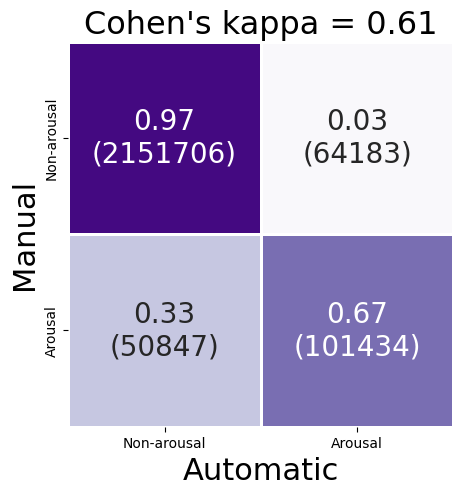

: 

In [ ]:
def plot_cm(true, pred, class_names, title, figsize=(5,5), fontsize=22):
     # Calculate comfusion matrix
    cm = confusion_matrix(true, pred)
    # Calculate the sum of true labels for each class and broadcast to cm shape
    row_sums = np.tile(cm.sum(axis=1)[:, np.newaxis], (1, cm.shape[0]))
    # Set normalized to 0.0 if there are zero true samples
    norm_cm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype='float'), where=row_sums!=0)
    norm_cm_df = pd.DataFrame(norm_cm, index=class_names, columns=class_names)

    # Create annotations in the format of '<normalized>\n(<count>)'
    formatter = "{0:.2f}".format
    annot = np.array([formatter(f) + '\n(' + str(d) + ')' for f, d in
                      zip(norm_cm.flatten(), cm.flatten())]).reshape(cm.shape)
    
    # Plot confusion matrix
    plt.figure(figsize=figsize)
    plt.axes().set_aspect('equal')
    sns.set_theme(font_scale=1.4)
    sns.heatmap(norm_cm_df,
                cmap=plt.cm.Purples,
                vmin=0.0,
                vmax=1.0,
                linecolor='white',
                linewidths=1,
                xticklabels=class_names,
                yticklabels=class_names,
                annot=annot,
                fmt='s',
                cbar=False,
                annot_kws={"size":fontsize-2})
    plt.title(title, fontsize=fontsize+1)
    plt.ylabel('Manual', fontsize=fontsize)
    plt.xlabel('Automatic', fontsize=fontsize)
    plt.show()

plot_cm(true_concat, pred_concat, class_names=['Non-arousal','Arousal'], title = f'Cohen\'s kappa = {kappa:.2f}', figsize=(5,5), fontsize=22)